# Practical Six: Semantic Segmentation

This notebook will introduce you to semantic segmentation in PyTorch. We will use pre-trained models available from [PyTorch Hub](https://pytorch.org/hub/), and model design and training are not within the scope of our course.

### References
* [PyTorch](https://pytorch.org/)
* [PyTorch Hub](https://pytorch.org/hub/)
* [Deeplabv3 (Content Credit)](https://pytorch.org/hub/pytorch_vision_deeplabv3_resnet101/)
* [Rethinking Atrous Convolution for Semantic Image Segmentation](https://arxiv.org/abs/1706.05587)

In [1]:
from PIL import Image, ImageChops, ImageFilter
import torch
from torchvision import transforms
import numpy as np

c:\Users\fhitl\anaconda3\envs\DNN_GREAT_SUCcess\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## Semantic Segmentation using DeepLabV3

Input RGB Image            |  Semantic Segmentation
:-------------------------:|:-------------------------:
![](../figs/deeplab1.png)  |  ![](../figs/deeplab2.png)

### Load a semantic segmentation model from PyTorch Hub

We will use DeepLabV3 models with ResNet-50 (`deeplabv3_resnet50`), ResNet-101 (`deeplabv3_resnet101`) and MobileNet-V3 (`deeplabv3_mobilenet_v3_large`) backbones from [PyTorch Hub](https://pytorch.org/hub/).

### Model Description

Deeplabv3-ResNet is constructed by a Deeplabv3 model using a ResNet-50 or ResNet-101 backbone.
Deeplabv3-MobileNetV3-Large is constructed by a Deeplabv3 model using the MobileNetV3 large backbone.
The pre-trained model has been trained on a subset of COCO train2017, on the 20 categories that are present in the Pascal VOC dataset.

Their accuracies of the pre-trained models evaluated on COCO val2017 dataset are listed below.

|    Model structure           |   Mean IoU  | Global Pixelwise Accuracy |
| ---------------------------- | ----------- | --------------------------|
| deeplabv3_resnet50           |   66.4      |   92.4                    |
| deeplabv3_resnet101          |   67.4      |   92.4                    |
| deeplabv3_mobilenet_v3_large |   60.3      |   91.2                    |

In [2]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_mobilenet_v3_large', pretrained=True)
model.eval()

Using cache found in C:\Users\fhitl/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\fhitl\anaconda3\envs\DNN_GREAT_SUCcess\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\fhitl\anaconda3\envs\DNN_GREAT_SUCcess\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape `(N, 3, H, W)`, where `N` is the number of images, `H` and `W` are expected to be at least `224` pixels. The images have to be loaded in to a range of `[0, 1]` and then normalized using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`.

The model returns an `OrderedDict` with two Tensors that are of the same height and width as the input Tensor, but with 21 classes with the following indexes `{'background':0, 'aeroplane':1, 'bicycle':2, 'bird':3, 'boat':4, 'bottle':5, 'bus':6, 'car':7, 'cat':8, 'chair':9, 'cow':10, 'dining table':11, 'dog':12, 'horse':13, 'motorbike':14, 'person':15, 'potted plant':16, 'sheep':17, 'sofa':18, 'train':19, 'tv/monitor':20}`. `output['out']` contains the semantic masks, and `output['aux']` contains the auxiliary loss values per-pixel. In inference mode, `output['aux']` is not useful. So, `output['out']` is of shape `(N, 21, H, W)` with

More documentation can be found [here](https://pytorch.org/vision/stable/models.html#semantic-segmentation).

### Test the semantic segmentation model on a sample image

In [3]:
filename = '../data/deeplab1.png'
input_image = Image.open(filename)
input_image = input_image.convert("RGB")
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)

In [4]:
# the list of all possible objects in the input image
objects = {
    0:'background',
    1:'aeroplane',
    2:'bicycle',
    3:'bird',
    4:'boat',
    5:'bottle',
    6:'bus',
    7:'car',
    8:'cat',
    9:'chair',
    10:'cow',
    11:'dining table',
    12:'dog',
    13:'horse',
    14:'motorbike',
    15:'person',
    16:'potted plant',
    17:'sheep',
    18:'sofa',
    19:'train',
    20:'tv/monitor'
}

print('The list of the objects in the image:')
for output_prediction in output_predictions.unique():
    print(objects[output_prediction.item()])

The list of the objects in the image:
background
person
sheep


The output here is of shape `(21, H, W)`, and at each location, there are unnormalized probabilities corresponding to the prediction of each class. To get the maximum prediction of each class, and then use it for a downstream task, you can do `output_predictions = output.argmax(0)`.

Here's a small snippet that displays the predictions, with each color being assigned to each class (see the visualized image on the left).

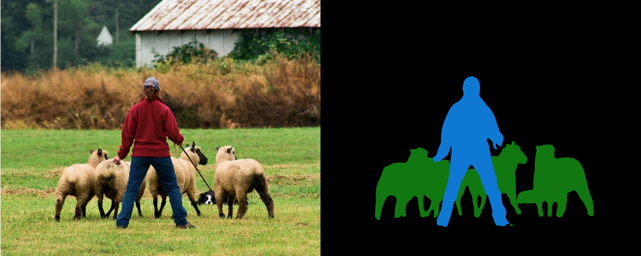

In [5]:
# create a color pallette, selecting a color for each class
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# display the semantic segmentation predictions of 21 classes in each color
semantic_image = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
semantic_image.putpalette(colors)

concat_image = Image.new('RGB', 
                         (input_image.width + semantic_image.width, 
                          max(input_image.height, semantic_image.height)), 
                         color=(0, 0, 0))

concat_image.paste(input_image, (0, 0))
concat_image.paste(semantic_image, (input_image.width, 0))
(width, height) = (concat_image.width // 4, concat_image.height // 4)
display(concat_image.resize((width, height)))

### Removing objects from the image

We can use semantic segmentation for a variety of applications. For instance, we can now remove pixels of particular objects from the input image. Here removing a pixel means simply making it the background. The following function does that.

In [6]:
def remove_object_pixels(model, input_image, objects_to_remove, show_object_list=False, concat=False, scale=1):
    """
    This function removes the pixels of the objects listed in 'objects_to_remove' from the input 'input_image'
    using the semantic segmentation 'model' and returns the modified image.
    """
    model.eval()
    
    preprocess = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
    
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)
    
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')
    
    with torch.no_grad():
        output = model(input_batch)['out'][0]
    output_predictions = output.argmax(0)
    
    objects = {
        0:'background',
        1:'aeroplane',
        2:'bicycle',
        3:'bird',
        4:'boat',
        5:'bottle',
        6:'bus',
        7:'car',
        8:'cat',
        9:'chair',
        10:'cow',
        11:'dining table',
        12:'dog',
        13:'horse',
        14:'motorbike',
        15:'person',
        16:'potted plant',
        17:'sheep',
        18:'sofa',
        19:'train',
        20:'tv/monitor'
    }
    
    objects_segmented = {}
    
    for output_prediction in output_predictions.unique().tolist():
        objects_segmented[output_prediction] = objects[output_prediction]
    
    if show_object_list:
        print(f'objects: {list(objects_segmented.values())}')
        
    
    mask = torch.zeros_like(output_predictions, dtype=torch.uint8)
    
    for key in objects_segmented.keys():
        if objects_segmented[key] not in objects_to_remove:
            index = (output_predictions == key)
            mask[index] = 255
            
    
    
    mask = transforms.ToPILImage()(mask).convert('RGB')
    
    masked_image = ImageChops.multiply(input_image, mask)
    
    output_image = masked_image.copy()
    
    if concat:
        output_image = Image.new('RGB', (input_image.width + masked_image.width, max(input_image.height, masked_image.height)))
        output_image.paste(input_image, (0, 0))
        output_image.paste(masked_image, (input_image.width, 0))
    
    if int(scale) > 1:
        (width, height) = (output_image.width // int(scale), output_image.height // int(scale))
        output_image = output_image.resize((width, height))
            
    return output_image

Now, we can test our function.

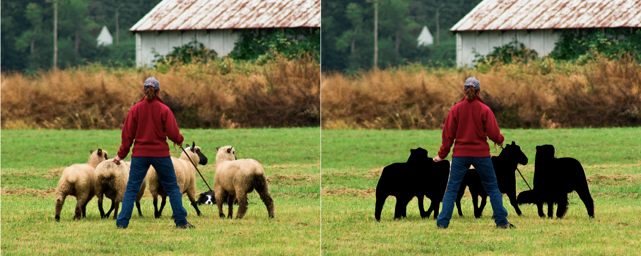

In [7]:
filename = '../data/deeplab1.png'
input_image = Image.open(filename)
input_image = input_image.convert("RGB")
output_image = remove_object_pixels(model, input_image, ['sheep'], concat=True, scale=4)
display(output_image)

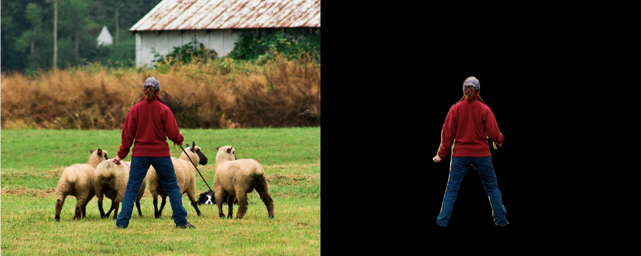

In [8]:
output_image = remove_object_pixels(model, input_image, ['sheep','background'], concat=True, scale=4)
display(output_image)

objects: ['background', 'bus', 'person']


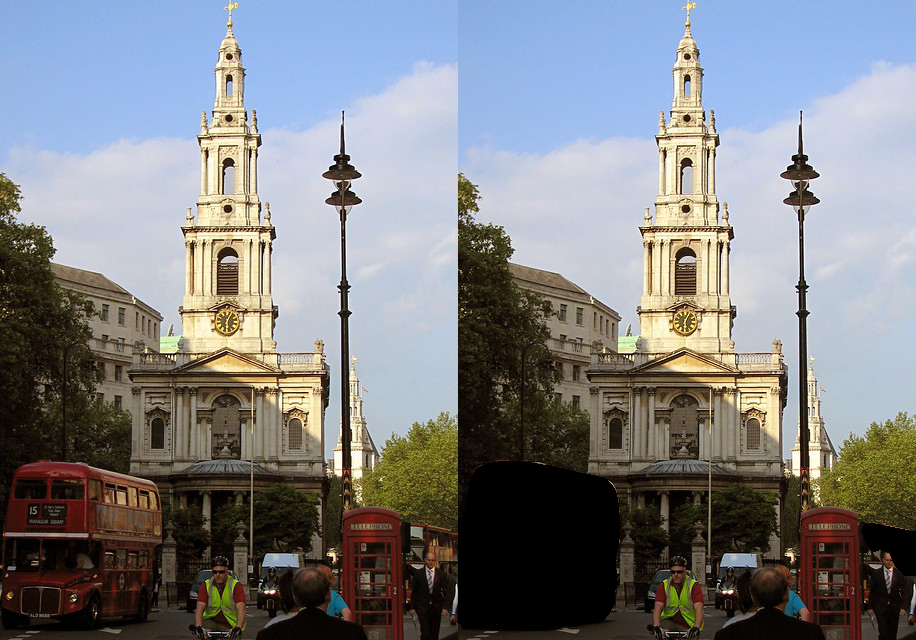

In [9]:
filename = '../data/deeplab2.jpg'
input_image = Image.open(filename)
input_image = input_image.convert("RGB")
output_image = remove_object_pixels(model, input_image, ['bus'], show_object_list=True, concat=True, scale=1)
display(output_image)

objects: ['background', 'person', 'potted plant']


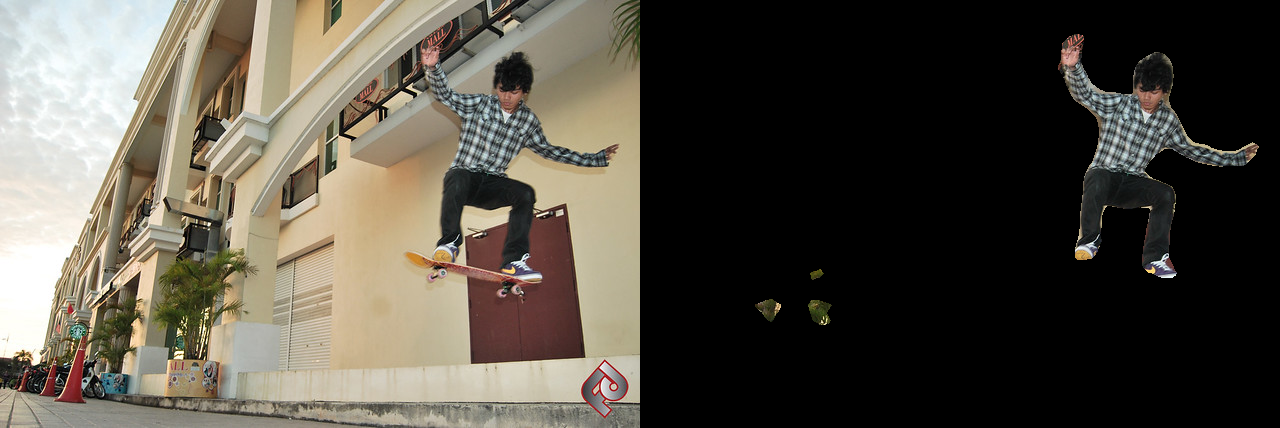

In [10]:
filename = '../data/deeplab3.jpg'
input_image = Image.open(filename)
input_image = input_image.convert("RGB")
output_image = remove_object_pixels(model, input_image, ['background'], show_object_list=True, concat=True, scale=1)
display(output_image)

objects: ['background', 'bicycle', 'motorbike', 'person']


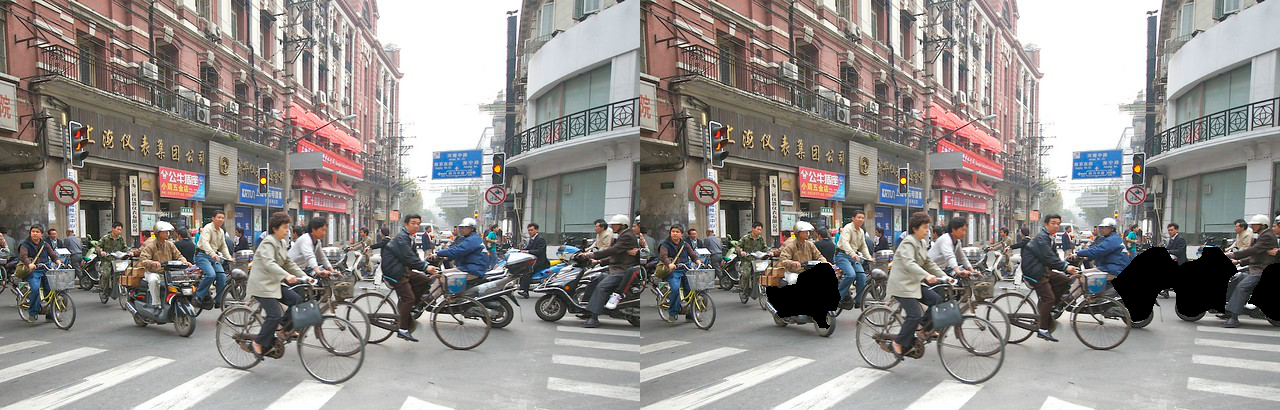

In [11]:
filename = '../data/deeplab4.jpg'
input_image = Image.open(filename)
input_image = input_image.convert("RGB")
output_image = remove_object_pixels(model, input_image, ['motorbike'], show_object_list=True, concat=True, scale=1)
display(output_image)

###  Bluring objects in the image

#### Your Task [30 Marks]

Another application of semantic segmentation is blurring image regions that belong to specific objects. For instance, the Google Street View Map application blurs human faces and vehicle license plates to protect privacy. Your task is to complete the function blur_object_pixels(...) to blur the pixels of specific objects provided by the user instead of removing them. The function should take the amount of blur as an input parameter. You may use isotropic Gaussian kernel of size $21 \times 21$ with a variable standard deviation to blur the image regions. See the function prototype below.

In [12]:
def blur_object_pixels(model, input_image, objects_to_blur, sigma=1.0, show_object_list=False, concat=False, scale=1):
    """
    This function blurs the pixels of the objects listed in 'objects_to_blur' on the input 'input_image'
    using the semantic segmentation 'model' and returns the modified image. The amount of blur is
    controlled by the parameter 'sigma'.
    """
    
    #COMPLETE AND CHANGE HERE
    model.eval()
    
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    input_tensor = preprocess(input_image).unsqueeze(0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    input_tensor = input_tensor.to(device)
    
    with torch.no_grad():
        output = model(input_tensor)['out'][0]
    output_predictions = output.argmax(0).cpu()
    
    blur_mask = Image.new("L", input_image.size, 0)
    blur_array = np.array(blur_mask)

    # Assuming class_indices is defined as shown earlier
    class_indices = {
        'background': 0,
        'aeroplane': 1,
        'bicycle': 2,
        'bird': 3,
        'boat': 4,
        'bottle': 5,
        'bus': 6,
        'car': 7,
        'cat': 8,
        'chair': 9,
        'cow': 10,
        'dining table': 11,
        'dog': 12,
        'horse': 13,
        'motorbike': 14,
        'person': 15,
        'potted plant': 16,
        'sheep': 17,
        'sofa': 18,
        'train': 19,
        'tv/monitor': 20
    }

    for label in objects_to_blur:
        label_index = class_indices[label]  # Convert label to index
        blur_array[output_predictions.numpy() == label_index] = 255

    blur_mask = Image.fromarray(blur_array)
    blurred_image = input_image.filter(ImageFilter.GaussianBlur(radius=sigma))
    blur_mask = blur_mask.resize(input_image.size, Image.NEAREST)

    final_image = ImageChops.composite(blurred_image, input_image, blur_mask)

    if concat:
        output_image = Image.new('RGB', (input_image.width * 2, input_image.height))
        output_image.paste(input_image, (0, 0))
        output_image.paste(final_image, (input_image.width, 0))
        final_image = output_image

    if scale > 1:
        output_image = final_image.resize((final_image.width // scale, final_image.height // scale))

    return output_image

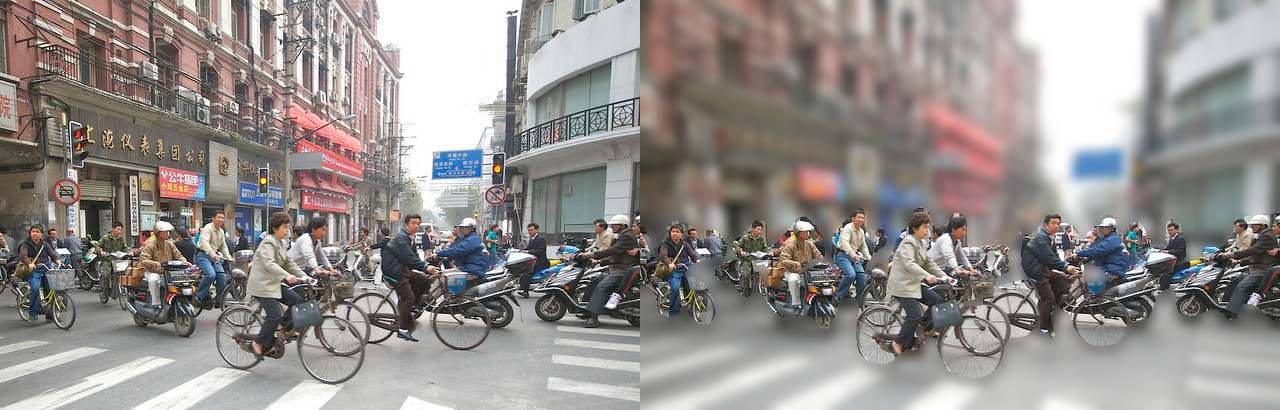

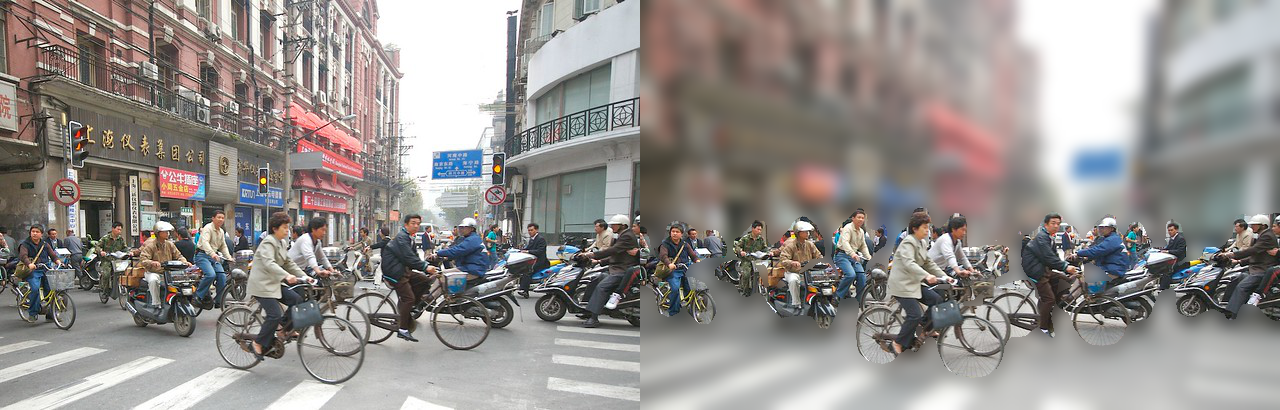

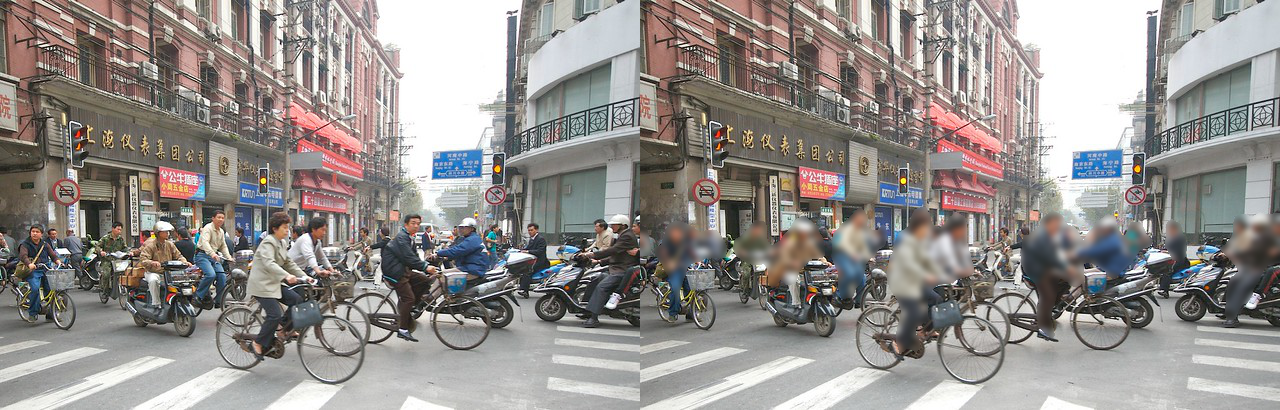

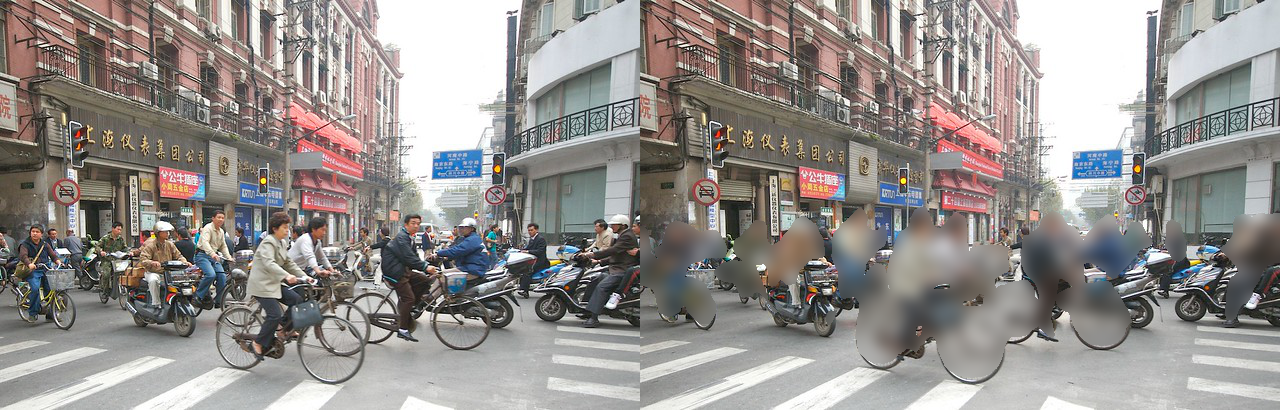

In [13]:
filename = '../data/deeplab4.jpg'
input_image = Image.open(filename)
input_image = input_image.convert("RGB")
output_image = blur_object_pixels(model, input_image, ['background'], sigma=5, show_object_list=False, concat=True, scale=1)
display(output_image)


filename = '../data/deeplab4.jpg'
input_image = Image.open(filename)
input_image = input_image.convert("RGB")
output_image = blur_object_pixels(model, input_image, ['background'], sigma=7, show_object_list=False, concat=True, scale=1)
display(output_image)

filename = '../data/deeplab4.jpg'
input_image = Image.open(filename)
input_image = input_image.convert("RGB")
output_image = blur_object_pixels(model, input_image, ['person'], sigma=3, show_object_list=False, concat=True, scale=1)
display(output_image)

filename = '../data/deeplab4.jpg'
input_image = Image.open(filename)
input_image = input_image.convert("RGB")
output_image = blur_object_pixels(model, input_image, ['person','bicycle'], sigma=7, show_object_list=False, concat=True, scale=1)
display(output_image)


With all this working you should be able to create the following outputs for the given code snippets:
```
filename = '../data/deeplab4.jpg'
input_image = Image.open(filename)
input_image = input_image.convert("RGB")
output_image = blur_object_pixels(model, input_image, ['background'], sigma=5, show_object_list=False, concat=True, scale=1)
display(output_image)
```
![](../figs/deeplab4_1.png)

```
filename = '../data/deeplab4.jpg'
input_image = Image.open(filename)
input_image = input_image.convert("RGB")
output_image = blur_object_pixels(model, input_image, ['background'], sigma=7, show_object_list=False, concat=True, scale=1)
display(output_image)
```
![](../figs/deeplab4_2.png)

```
filename = '../data/deeplab4.jpg'
input_image = Image.open(filename)
input_image = input_image.convert("RGB")
output_image = blur_object_pixels(model, input_image, ['person'], sigma=3, show_object_list=False, concat=True, scale=1)
display(output_image)
```
![](../figs/deeplab4_3.png)

```
filename = '../data/deeplab4.jpg'
input_image = Image.open(filename)
input_image = input_image.convert("RGB")
output_image = blur_object_pixels(model, input_image, ['person','bicycle'], sigma=7, show_object_list=False, concat=True, scale=1)
display(output_image)
```
![](../figs/deeplab4_4.png)

### Evaluating the performances of DeepLabV3 models

#### Your Task [30 Marks]

Use DeepLabV3 models with ResNet-50 (`deeplabv3_resnet50`), ResNet-101 (`deeplabv3_resnet101`) and MobileNet-V3 (`deeplabv3_mobilenet_v3_large`) backbones from [PyTorch Hub](https://pytorch.org/hub/) on sample images under the `../data/` folder and compare their performances in terms of computing times and segmentation accuracy.

In [14]:
import torch
import torchvision.transforms as T
from PIL import Image
import os
import time
import numpy as np

# Load models from PyTorch Hub
deeplabv3_resnet50 = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
deeplabv3_resnet101 = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)
deeplabv3_mobilenet_v3_large = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_mobilenet_v3_large', pretrained=True)

# Function to generate and save masks
def generate_and_save_masks(image_dir, mask_dir, model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    preprocess = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    os.makedirs(mask_dir, exist_ok=True)
    
    for image_name in os.listdir(image_dir):
        if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):  # Check if it's an image file
            image_path = os.path.join(image_dir, image_name)
            try:
                image = Image.open(image_path).convert("RGB")
            except IOError as e:
                print(f"Error opening image {image_path}: {e}. Skipping...")
                continue
            
            input_tensor = preprocess(image).unsqueeze(0).to(device)
            
            with torch.no_grad():
                output = model(input_tensor)['out'][0]
            
            output_predictions = output.argmax(0).byte()
            mask = T.ToPILImage()(output_predictions)
            mask.save(os.path.join(mask_dir, image_name.replace('.jpg', '_mask.png')))

# Path setup
image_dir = '../data'
mask_dir = '../data/masks'

# Generate masks using a pre-trained model
generate_and_save_masks(image_dir, mask_dir, deeplabv3_resnet101)

# Function to load image and mask
def load_image_and_mask(image_path, mask_path):
    image = Image.open(image_path).convert("RGB")
    mask = Image.open(mask_path).convert("L")
    
    preprocess = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image_tensor = preprocess(image).unsqueeze(0)
    
    mask_tensor = T.ToTensor()(mask) * 255
    mask_tensor = mask_tensor.long().squeeze()
    
    return image_tensor, mask_tensor

# Evaluate model
def evaluate_model(model, device, image_mask_paths):
    model.eval()
    model.to(device)
    times = []
    iou_scores = []
    
    for image_path, mask_path in image_mask_paths:
        image, true_mask = load_image_and_mask(image_path, mask_path)
        image, true_mask = image.to(device), true_mask.to(device)
        
        start_time = time.time()
        with torch.no_grad():
            output = model(image)['out']
        end_time = time.time()
        
        times.append(end_time - start_time)
        preds = output.argmax(1).squeeze(0)
        iou_scores.append(np.mean((preds == true_mask).cpu().numpy()))
    
    return np.mean(times), np.mean(iou_scores)

# Prepare image and mask paths
image_mask_paths = [(os.path.join(image_dir, f), os.path.join(mask_dir, f.replace('.jpg', '_mask.png')))
                    for f in os.listdir(image_dir) if f.endswith('.jpg')]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Evaluate all models
results = {}
models = [deeplabv3_resnet50, deeplabv3_resnet101, deeplabv3_mobilenet_v3_large]
model_names = ['ResNet-50', 'ResNet-101', 'MobileNet-V3']

for model, name in zip(models, model_names):
    times, ious = evaluate_model(model, device, image_mask_paths)
    results[name] = {'Time': times, 'IoU': ious}

# Print results
for name, metrics in results.items():
    print(f"{name}: Time - {metrics['Time']}s, IoU - {metrics['IoU']}")


Using cache found in C:\Users\fhitl/.cache\torch\hub\pytorch_vision_v0.10.0
Using cache found in C:\Users\fhitl/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\fhitl\anaconda3\envs\DNN_GREAT_SUCcess\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Using cache found in C:\Users\fhitl/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\fhitl\anaconda3\envs\DNN_GREAT_SUCcess\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_MobileNet_V3_L

ResNet-50: Time - 1.3693838119506836s, IoU - 0.983013616747692
ResNet-101: Time - 1.915632963180542s, IoU - 1.0
MobileNet-V3: Time - 0.17272774378458658s, IoU - 0.9594524745175969


### Another application of semantic segmentation

#### Your Task [40 Marks]

Find another application of semantic segmentation and provide a brief description of why you decided to choose this specific application. Then, use DeepLabV3 model with ResNet-50 (`deeplabv3_resnet50`) backbone from [PyTorch Hub](https://pytorch.org/hub/) to implement the application and demonstrate your implementation in this notebook. Note that the originality of the application will get high marks.

I chose to identify if a person was in a space on video. This is a use case we have discussed at work, regarding the use of heavy machinery in production facilities in relation to health and safety. Some areas are forbidden to be in while machinery is in action. The next step would be to detect if a worker uses a hard hat in the designated areas. The video is quite slow due to the framerate i chose. I did this to visualy analyse the performance and make sure the segmentation does not "jump" to much. The video can be made faster or slower by changing the `fps` variable in the code below. The video with the segmentation can be found [here](../data/segmented_video.mp4). (You may have to open the video in the media player to view it)


In [21]:
import torchvision
import cv2
import torch
import time
import torchvision.transforms as transforms
import numpy as np
import os

# Define the label color map for visualization
label_color_map = [
    (0, 0, 0),  # background
    (128, 0, 0), # aeroplane
    (0, 128, 0), # bicycle
    (128, 128, 0), # bird
    (0, 0, 128), # boat
    (128, 0, 128), # bottle
    (0, 128, 128), # bus
    (128, 128, 128), # car
    (64, 0, 0), # cat
    (192, 0, 0), # chair
    (64, 128, 0), # cow
    (192, 128, 0), # dining table
    (64, 0, 128), # dog
    (192, 0, 128), # horse
    (64, 128, 128), # motorbike
    (192, 128, 128), # person
    (0, 64, 0), # potted plant
    (128, 64, 0), # sheep
    (0, 192, 0), # sofa
    (128, 192, 0), # train
    (0, 64, 128)  # tv/monitor
]

# Transform for image preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Functions to process images and extract labels
def get_segment_labels(image, model, device):
    image = transform(image).to(device)
    image = image.unsqueeze(0)  # add a batch dimension
    outputs = model(image)
    return outputs

def draw_segmentation_map(outputs):
    labels = torch.argmax(outputs.squeeze(), dim=0).detach().cpu().numpy()
    segmentation_map = np.zeros((labels.shape[0], labels.shape[1], 3), dtype=np.uint8)
    for label_num, color in enumerate(label_color_map):
        segmentation_map[labels == label_num] = color
    return segmentation_map

def image_overlay(image, segmented_image):
    alpha = 1
    beta = 0.8
    gamma = 0
    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)
    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)

# Setup video reading and writing
video_input_path = '../data/input/video_1.mp4'
output_folder = '../data/outputs'

# Ensure output folder exists
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True).eval().to(device)

cap = cv2.VideoCapture(video_input_path)
if not cap.isOpened():
    print('Error while trying to read video. Please check path again')

frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
save_name = video_input_path.split('/')[-1].split('.')[0]
out = cv2.VideoWriter(f"{output_folder}/{save_name}.mp4", cv2.VideoWriter_fourcc(*'avc1'), 3, (frame_width, frame_height))

# Process video
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret:
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        outputs = get_segment_labels(rgb_frame, model, device)
        segmented_image = draw_segmentation_map(outputs['out'])
        final_image = image_overlay(rgb_frame, segmented_image)
        final_image_bgr = cv2.cvtColor(final_image, cv2.COLOR_RGB2BGR)
        out.write(final_image_bgr)  # Write processed frame to output
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

cap.release()
out.release()
cv2.destroyAllWindows()
print('Video processing complete. Output saved to:', f"{output_folder}/{save_name}.mp4")


Video processing complete. Output saved to: ../data/outputs/video_1.mp4


# Submission

Answer the questions, zip your entire folder and submit it on Canvas under Assignment 6.